Import libraries:
- **Pandas** - for storing, exploring and manipulating our data.
- **scikit-learn** (sklearn) - for ML models (Decision Tree and Random Forest)

# Sample


In [21]:
# Import libraries: pandas, scikit-learn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
# Feature Engineering
import seaborn as sns
import matplotlib.pyplot as plt

Our data is stored in a csv file specified in the path then we load it into pandas DataFrame.

In [22]:
# Dataset: home prices in Iowa (stored in local)
iowa_file_path = "./data/iowa_home.csv"

# Read csv file and load it as a DataFrame
iowa_data = pd.read_csv(iowa_file_path)

### Exploring our data (Initial)
Now let's analyze and view the summary statistics of our data. We'll use the following:
- DataFrame.shape - returns the dimensionality (rows x columns) of the DataFrame.
- DataFrame.describe() - gives us descriptive statistics of our data.
- DataFrame.head([n]) - returns first n rows.

Learn more about [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/index.html) capabilities.


From our output, we're dealing with 1460 data of Iowa Homes with its features and price.


In [3]:
# Print summary statistics of data
print(iowa_data.shape)
print(iowa_data.describe()) # describe numeric data
print(iowa_data.head(5)) # display first 5 rows
#iowa_data.info()

(1460, 81)
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456

### Data Cleaning

Since we have 81 variables/columns of Iowa data consisting of features and our target (Price), we will just choose the numeric types that we consider as a good feature of price.  

After checking for NaN values in our dataset, the features: Alley, PoolQC, Fence and MiscFeature have too many NaNs. It will be better to remove them. Luckily, our target variable SalePrice doesn't have any.

Note that Lot Frontage has NaNs but in this project, I decided to handle these NaNs by replacing it to 0. The reason why is Lot Frontage may be a good feature in predicting prices. It is [defined](https://www.gimme-shelter.com/frontage-50043/) as a width of a lot, measured at the front part of the lot. 

In [4]:
# Check for NaN values in our features
null_columns=iowa_data.columns[iowa_data.isnull().any()]
iowa_data[null_columns].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [17]:
# Selecting prediction target using dot notation in pandas
iowa_target = iowa_data.SalePrice

# For this project, we will only include numeric features. Drop columns because of many NaNs and the target 
to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'SalePrice'] 
features = iowa_data.drop(to_drop, axis=1).select_dtypes(exclude=['object']) # axis=1 indicates to drop columns

# Change NA values in Lot Frontage as 0
values = {'LotFrontage': 0}
features = features.fillna(value=values)

### Data Exploration
Now that we have a clean data, now is the time to explore it.

From the outputs below, the latest home built was in 2010. Why? Let's take a look at the histogram below. Looks like our dataset hasn't been updated after 2010 considering the number of homes constructed in that year. If we consider a new home built in 2019 and use our model to predict the price, we cannot say with confidence that it's accurate because our model found patterns from homes built in previous years until 2010. 

Latest home that was built is in the year 2010


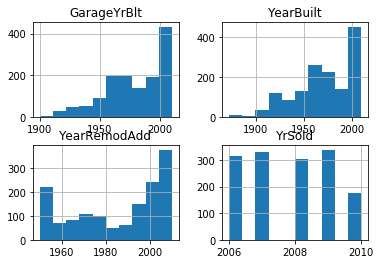

In [6]:
# Latest home that was built
print("Latest home that was built is in the year %s" %(int(features["YearBuilt"].max())))

# Histogram
features.hist(column=["YrSold","YearBuilt","YearRemodAdd","GarageYrBlt"]);

### Feature Engineering

Some features in our data are irrelevant. We need to select best predictors of Iowa homes prices.

In this project, we will explore correlation using seaborn, matplotlib and pandas libraries. [Correlation](https://www.datascience.com/blog/introduction-to-correlation-learn-data-science-tutorials) can be used to observe relationship between variables. There are other techniques for finding good predictors but need time to research and implement.

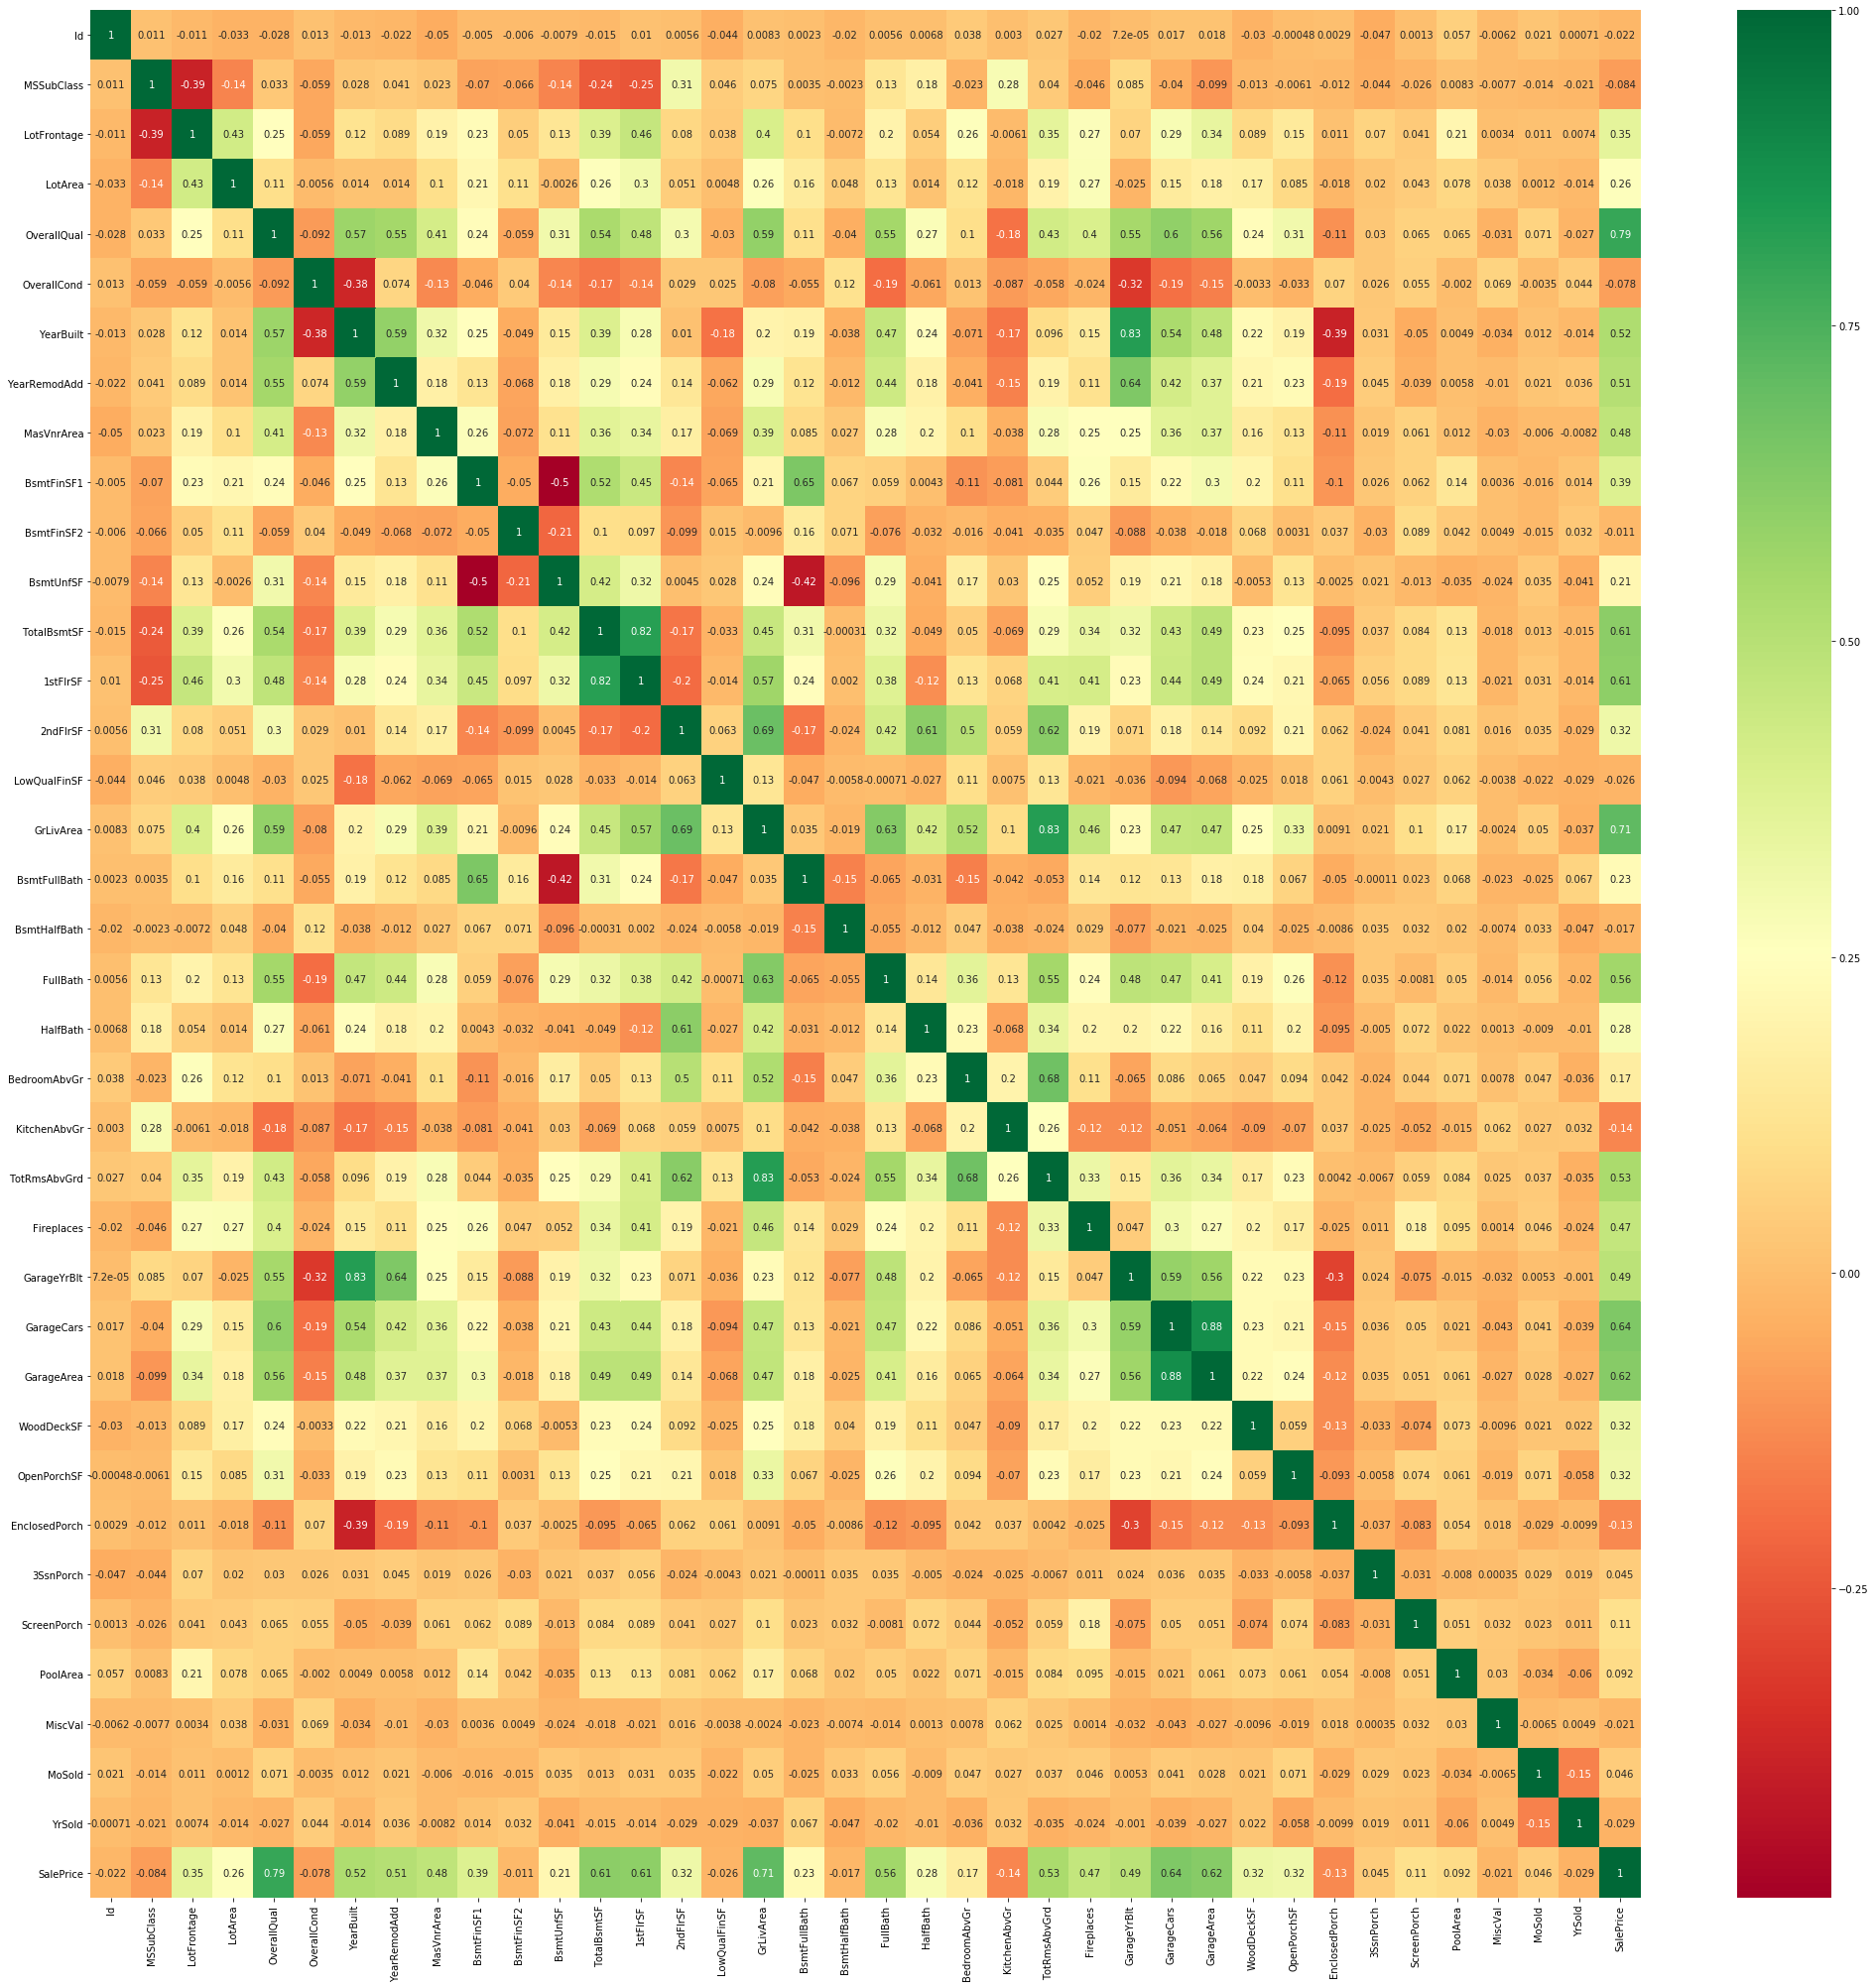

In [7]:
# Correlation Matrix with Seaborn Heatmap
# Get correlations of each numeric features in dataset
df = iowa_data.select_dtypes(exclude=['object'])
corrmat = df.corr()
top_corr_features = corrmat.index

plt.figure(figsize=(35,35))
# Plot heat map using seaborn
g = sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [8]:
# Take absolute value of all correlation coeff
corr_matrix = corrmat.abs()

# Obtain a series named SalePrice with index of features with correlated coefficient > 0.60 wrt SalePrice
df = corr_matrix['SalePrice']
corr_features = [idx for idx, value in df.iteritems() if value > 0.60]
print(corr_features)

['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars', 'GarageArea', 'SalePrice']


The above code gets the features correlated with the sale price with correlation coefficient > 0.60.  

In [23]:
# Possible good features
iowa_features = ['LotFrontage', 'LotArea', 'YearBuilt', 'GarageArea',
                 '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GrLivArea',
                 'OverallQual', 'TotalBsmtSF', 'YearRemodAdd']
features = features[iowa_features]

# Combine features and target. Make a csv file that we will used for XGBoost
filtered_data = features.join(iowa_target)
filtered_data.to_csv('./data/iowa_home_filtered.csv')


Now that we selected good features of our target variable, we will split our dataset into training and validation data. Training data will be used for training our model i.e. find patterns then use the validation data to measure model's quality. 

In [24]:
# Split data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    iowa_target,
                                                    train_size=0.7, 
                                                    test_size=0.3, 
                                                    random_state=0)

### Predictive Modeling
This is where amazing happens. Here's the steps:
1. Define model
2. Train/Fit - captures patterns in training data
3. Predict - predict from new data
4. Validate/Evaluate - check if model's prediction is accurate

We will explore *DecisionTrees* and *RandomForest* (Regressor)

**Model Validation**

Mean Absolute Error (MAE) - one of the metrics for summarizing model quality. This can be calculated by taking the difference of actual and predicted values (take abs value) then compute for the mean.
$$MAE =\frac{1}{n}\sum_{i=1}^n \mid{y_i - \hat{y}_i} \mid$$

In [25]:
# Define and train model using training data. Specify a number for random_state to ensure same results each run
iowa_model = DecisionTreeRegressor(random_state=0)
iowa_model.fit(X_train, y_train)

# Predict using validation/test data
predictions = iowa_model.predict(X_test)

# Model validation: measure the quality of models (Predictive Accuracy)
print("On average, our predictions are off by about $ %.2f by using a Decision Tree" %(mean_absolute_error(y_test, predictions)))

On average, our predictions are off by about $ 26031.89 by using a Decision Tree


**Model Tuning**

Can we improve our model's accuracy? Of course. We will explore a parameter: max_leaf_nodes of the DecisionTreeRegressor model. Given a list of max_leaf_nodes, we will find the best value that will make our model more accurate.

In [26]:
# Compare MAE with differing values of max_leaf_nodes
candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
scores = {leaf_size: get_mae(leaf_size, X_train, X_test, y_train, y_test) for leaf_size in candidate_max_leaf_nodes}

# Store the best value of max_leaf_nodes
best_tree_size = min(scores, key=scores.get)
print("Best tree size (value of max_leaf_nodes) is %d with MAE score of %.2f" %(best_tree_size, scores[best_tree_size]))

Best tree size (value of max_leaf_nodes) is 100 with MAE score of 25080.46


In [13]:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    # Help compare mae scores
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

**Random Forest**

Let's check a new model called Random Forest and if it will provide a better predictive accuracy than Decision Trees.

*Overview:* The random forest uses many trees, and it makes a prediction by averaging the predictions of each component tree. It generally has much better predictive accuracy than a single decision tree and it works well with default parameters.

From the output below, the random forest provides a better approximations of our dataset compared to decision trees.

In [27]:
# Random Forest - ML model
forest_model = RandomForestRegressor(random_state=0, n_estimators=1000)
forest_model.fit(X_train, y_train)
iowa_preds = forest_model.predict(X_test)
print("On average, our predictions are off by about $ %.2f by using Random Forest" %(mean_absolute_error(y_test, iowa_preds)))

On average, our predictions are off by about $ 18734.10 by using Random Forest


### Conclusion
There's no conclusion in a Data Science project until the business accepts our insights/analysis. The workflow will be a continuous process and we will analyze new data, select best predictors/features and find the right models that give us best approximations.
